In [1]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp
import copy

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu/info/plug

In [2]:
%load_ext autoreload
%autoreload 2

## Load SXR phantoms

In [3]:
# Load phantom data
psis = np.load('../dataset_generation/sxr_samples_fine_gaussian_background/psis.npy')
sxr_samples = np.load('../dataset_generation/sxr_samples_fine_gaussian_background/sxr_samples.npy')
alphas = np.load('../dataset_generation/sxr_samples_fine_gaussian_background/alpha_random_values.npy')
trim_val = np.load('../dataset_generation/sxr_samples_fine_gaussian_background/trimming_values.npy')
random_peak_vals = np.load('../dataset_generation/sxr_samples_fine_gaussian_background/peak_values.npy')

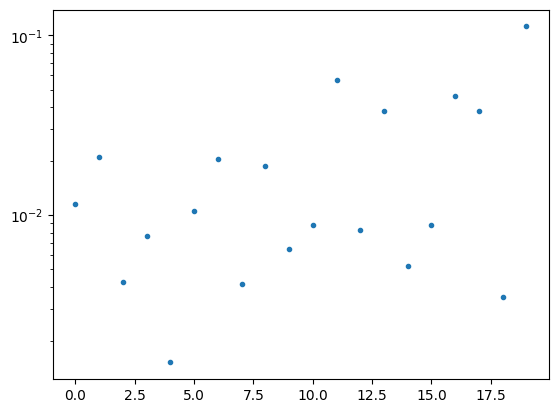

In [4]:
plt.plot(alphas[:20], '.')
plt.yscale('log')

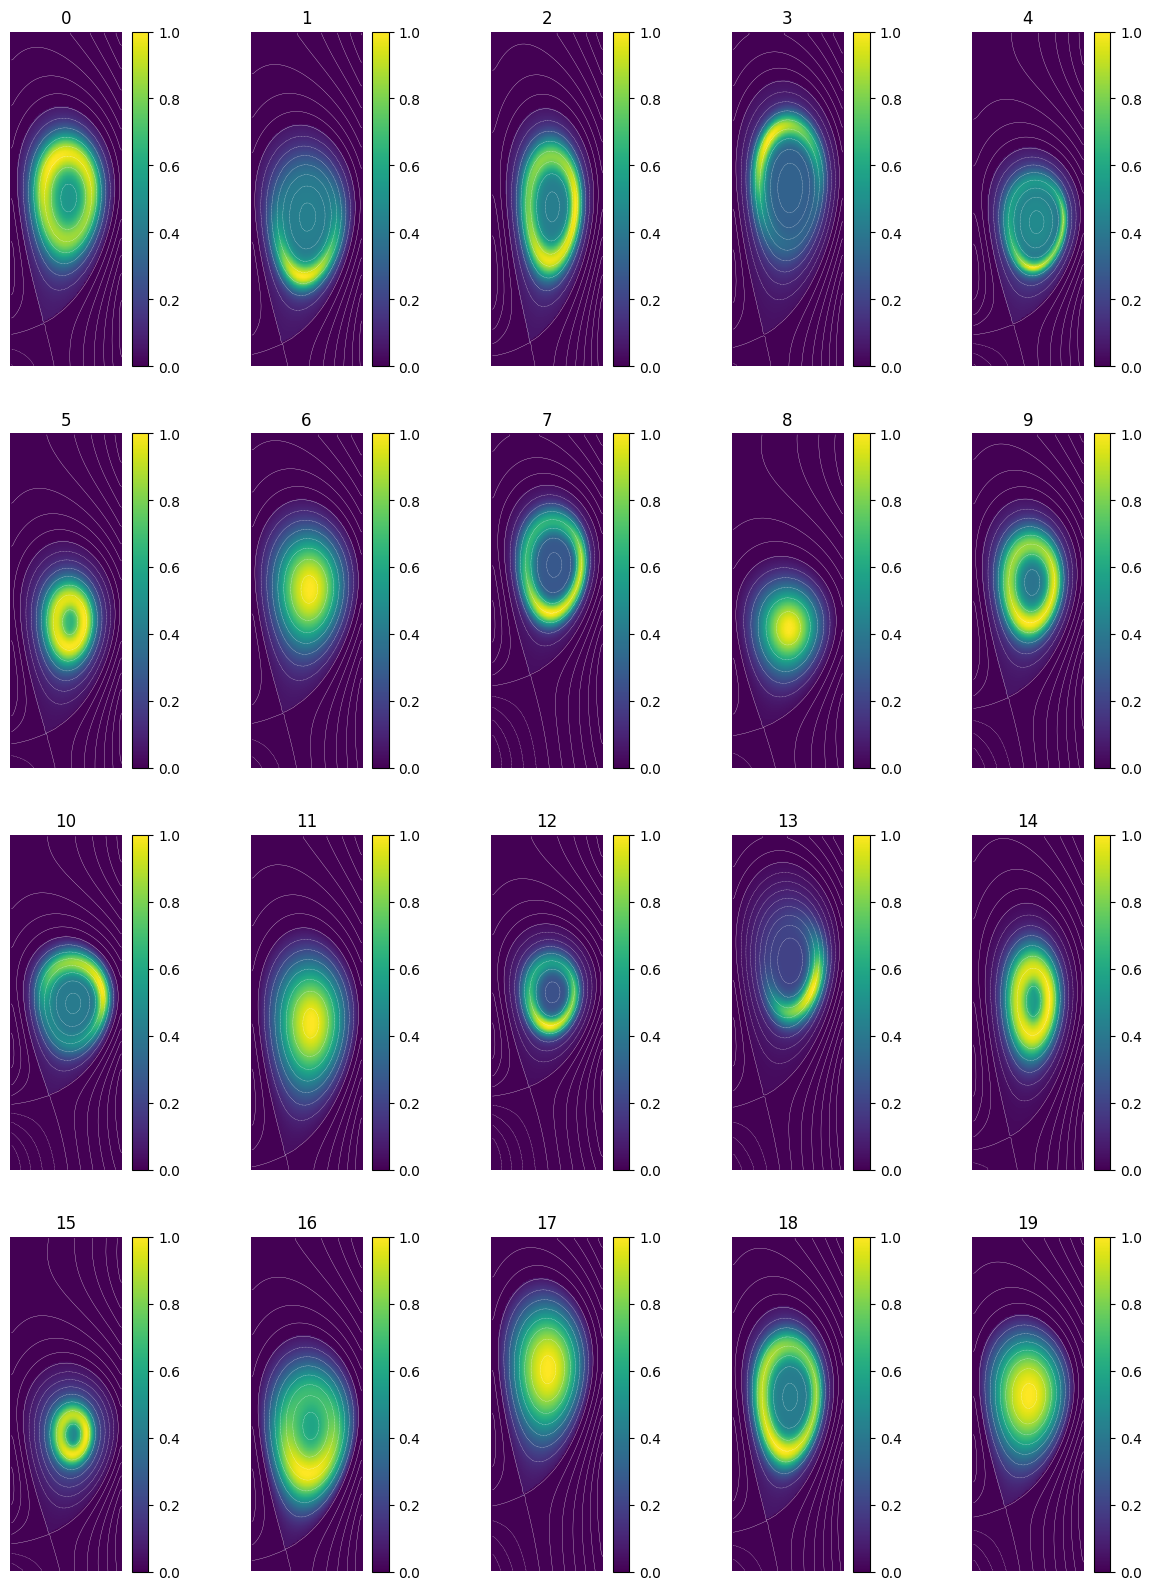

In [5]:
fig,ax=plt.subplots(4,5, figsize=(15,20))
for i in range(4):
    for j in range(5):
        im=ax[i,j].imshow(sxr_samples[i*5+j, 0, :, :].squeeze())
        ax[i, j].contour(psis[i*5+j, :, :], origin="lower", levels=15, antialiased=True, colors="w", linewidths=0.2)
        plt.colorbar(im, ax=ax[i,j])
        ax[i,j].axis('off')
        ax[i,j].set_title("{}".format(i*5+j))
plt.show()

## Study influence of coherence enhancing vs anisotropic prior

In [9]:
idx = 0

ground_truth= copy.deepcopy(sxr_samples[idx,0,:,:].squeeze())
psi=psis[idx,:,:]
alpha=alphas[idx]
trim_val_=trim_val[idx,:]
mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=(120,40), trim_values_x=trim_val_)
mask_core_fine = tomo_helps.define_core_mask(psi=psi, dim_shape=psi.shape, trim_values_x=trim_val_)

# NEED TO PLOT IT DIFFERENTLY, CHANGING DEFINITION FUNCTIONAL FUNCTION TO ALLOW FINE GRID...

# Define functionals
_, g_coherence = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi, reconstruction_shape=(1,240,80),
                                                 sigma_err=1e-2, reg_fct_type="coherence_enhancing",
                                                 alpha=alpha, plot=False,
                                                 seed=idx)
_, g_anisotropic = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi, reconstruction_shape=(1,240,80),
                                                 sigma_err=1e-2, reg_fct_type="anisotropic",
                                                 alpha=alpha, plot=False,
                                                 seed=idx)

In [186]:
import pyxu_diffops.operator as px_diffops
sampling = 1.5/240
g_coherence = px_diffops.AnisCoherenceEnhancingDiffusionOp(dim_shape=(1,240,80),
                                                        alpha=alpha,
                                                        m=1,
                                                        diff_method_struct_tens="fd",
                                                        sigma_gd_st=1*sampling,
                                                        smooth_sigma_st=2*sampling,
                                                        freezing_arr=psi,
                                                        sampling=sampling,
                                                        matrix_based_impl=True)

In [187]:
sampling = 1.5/120
psi_coarse = skimt.resize(psi, (120,40), anti_aliasing=False)
g_coherence_coarse = px_diffops.AnisCoherenceEnhancingDiffusionOp(dim_shape=(1,120,40),
                                                        alpha=alpha,
                                                        m=1,
                                                        diff_method_struct_tens="fd",
                                                        sigma_gd_st=0*sampling,
                                                        smooth_sigma_st=1*sampling,
                                                        freezing_arr=psi_coarse,
                                                        sampling=sampling,
                                                        matrix_based_impl=True)

In [188]:
coeff_coherence_enhancing = g_coherence.diffusion_coefficient.frozen_coeff
coeff_coherence_enhancing_coarse = g_coherence_coarse.diffusion_coefficient.frozen_coeff
coeff_anisotropic = g_anisotropic.diffusion_coefficient.frozen_coeff
print(coeff_coherence_enhancing.shape, coeff_anisotropic.shape)

(2, 2, 1, 240, 80) (2, 2, 1, 240, 80)


Text(0.5, 1.0, '$D_{xy}$ (anisotropic)')

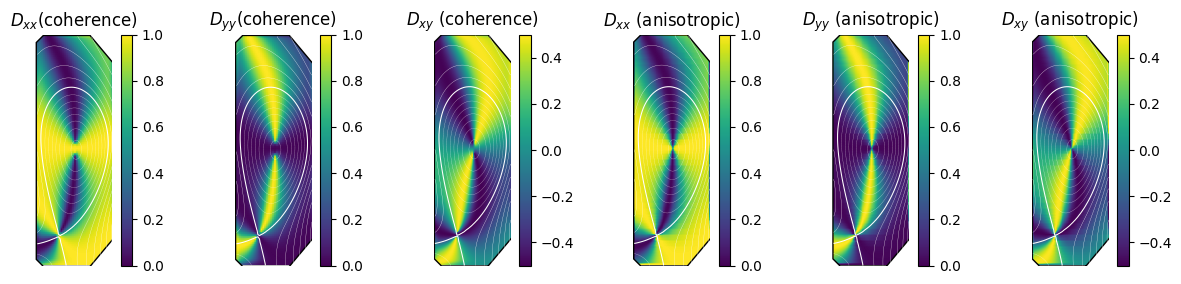

In [189]:
fig, ax = plt.subplots(1,6, figsize=(15,3))

# number of pixels
nb_pixels = g_anisotropic.dim_size
# number of pixels
nb_pixels = g_anisotropic.dim_size

tomo_plots.plot_profile(coeff_coherence_enhancing_coarse[0,0,0,:,:], tcv_plot_clip=True, contour_image=psi_coarse, levels=15, ax=ax[0], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
ax[0].set_title(r"$D_{xx}$(coherence)")
tomo_plots.plot_profile(coeff_coherence_enhancing_coarse[1,1,0,:,:], tcv_plot_clip=True, contour_image=psi_coarse, levels=15, ax=ax[1], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
ax[1].set_title(r"$D_{yy}$(coherence)")
# tomo_plots.plot_profile(coeff_coherence_enhancing[0,0,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[0], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
# ax[0].set_title(r"$D_{xx}$(coherence)")
# tomo_plots.plot_profile(coeff_coherence_enhancing[1,1,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[1], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
# ax[1].set_title(r"$D_{yy}$ (coherence)")
tomo_plots.plot_profile(coeff_coherence_enhancing[0,1,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[2], colorbar=True, vmin=-0.5, vmax=0.5, cmap="viridis", contour_color="w")
ax[2].set_title(r"$D_{xy}$ (coherence)")

tomo_plots.plot_profile(coeff_anisotropic[0,0,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[3], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
ax[3].set_title(r"$D_{xx}$ (anisotropic)")
tomo_plots.plot_profile(coeff_anisotropic[1,1,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[4], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
ax[4].set_title(r"$D_{yy}$ (anisotropic)")
tomo_plots.plot_profile(coeff_anisotropic[0,1,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[5], colorbar=True, vmin=-0.5, vmax=0.5, cmap="viridis", contour_color="w")
ax[5].set_title(r"$D_{xy}$ (anisotropic)")


Text(0.5, 1.0, '$D_{xy}$ (anisotropic)')

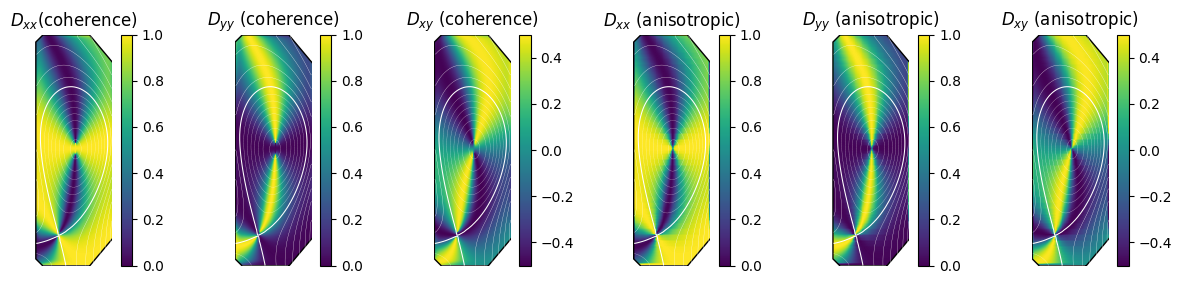

In [190]:
fig, ax = plt.subplots(1,6, figsize=(15,3))

# number of pixels
nb_pixels = g_anisotropic.dim_size

# tomo_plots.plot_profile(coeff_coherence_enhancing_coarse[0,0,0,:,:], tcv_plot_clip=True, contour_image=psi_coarse, levels=15, ax=ax[0], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
# ax[0].set_title(r"$D_{xx}$(coherence)")
# tomo_plots.plot_profile(coeff_coherence_enhancing_coarse[1,1,0,:,:], tcv_plot_clip=True, contour_image=psi_coarse, levels=15, ax=ax[1], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
# ax[1].set_title(r"$D_{yy}$(coherence)")
tomo_plots.plot_profile(coeff_coherence_enhancing[0,0,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[0], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
ax[0].set_title(r"$D_{xx}$(coherence)")
tomo_plots.plot_profile(coeff_coherence_enhancing[1,1,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[1], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
ax[1].set_title(r"$D_{yy}$ (coherence)")
tomo_plots.plot_profile(coeff_coherence_enhancing[0,1,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[2], colorbar=True, vmin=-0.5, vmax=0.5, cmap="viridis", contour_color="w")
ax[2].set_title(r"$D_{xy}$ (coherence)")

tomo_plots.plot_profile(coeff_anisotropic[0,0,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[3], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
ax[3].set_title(r"$D_{xx}$ (anisotropic)")
tomo_plots.plot_profile(coeff_anisotropic[1,1,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[4], colorbar=True, vmin=0, vmax=1, cmap="viridis", contour_color="w")
ax[4].set_title(r"$D_{yy}$ (anisotropic)")
tomo_plots.plot_profile(coeff_anisotropic[0,1,0,:,:], tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[5], colorbar=True, vmin=-0.5, vmax=0.5, cmap="viridis", contour_color="w")
ax[5].set_title(r"$D_{xy}$ (anisotropic)")


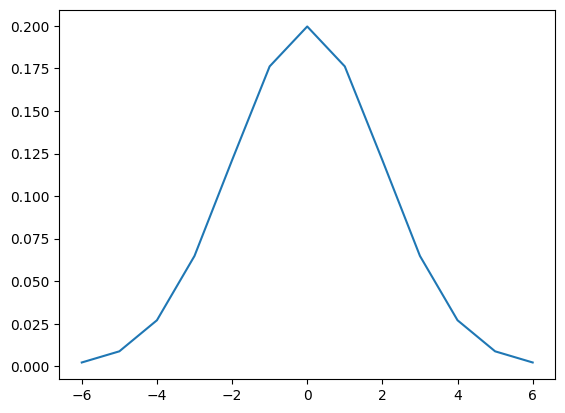

In [191]:
ll=np.linspace(-6,6,13)
ss=2
llp=np.exp(-0.5/ss**2 * ll**2)
plt.plot(ll,llp/np.sum(llp))


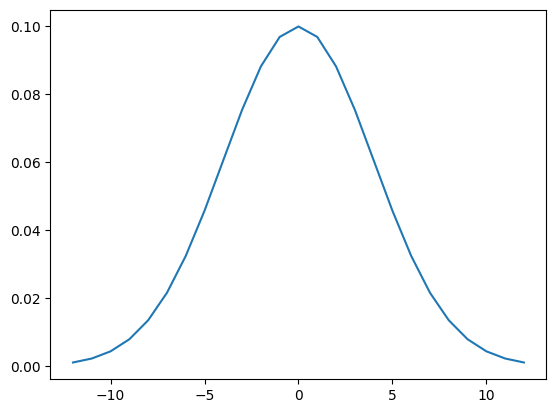

In [194]:
ll=np.linspace(-12,12,25)
ss=4
llp=np.exp(-0.5/ss**2 * ll**2)
plt.plot(ll,llp/np.sum(llp))

Text(0.5, 1.0, '$\\vert D_{xy}^{coh}-D_{xy}^{anis}\\vert$')

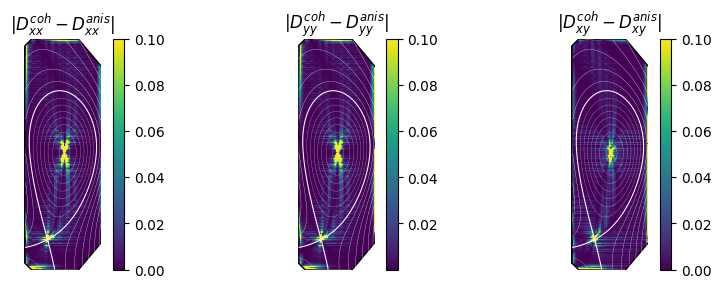

In [199]:
fig, ax = plt.subplots(1,3, figsize=(10,3))

# number of pixels
nb_pixels = g_anisotropic.dim_size

tomo_plots.plot_profile(np.abs(coeff_coherence_enhancing[0,0,0,:,:]-coeff_anisotropic[0,0,0,:,:]), tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[0], colorbar=True, vmin=0, vmax=0.1, cmap="viridis", contour_color="w")
ax[0].set_title(r"$\vert D_{xx}^{coh}-D_{xx}^{anis}\vert$")
tomo_plots.plot_profile(np.abs(coeff_coherence_enhancing[1,1,0,:,:]-coeff_anisotropic[1,1,0,:,:]), tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[1], colorbar=True, vmin=None, vmax=0.1, cmap="viridis", contour_color="w")
ax[1].set_title(r"$\vert D_{yy}^{coh}-D_{yy}^{anis}\vert$")
tomo_plots.plot_profile(np.abs(coeff_coherence_enhancing[0,1,0,:,:]-coeff_anisotropic[0,1,0,:,:]), tcv_plot_clip=True, contour_image=psi, levels=15, ax=ax[2], colorbar=True, vmin=0, vmax=0.1, cmap="viridis", contour_color="w")
ax[2].set_title(r"$\vert D_{xy}^{coh}-D_{xy}^{anis}\vert$")



In [200]:
gg=np.load('../dataset_generation/magnetic_equilibrium.npy')

In [201]:
gg.max()

np.float64(28.006723811849955)

In [202]:
psi.max()

np.float64(22.32860247604549)

# Hyperparameter tuning

We run hyperparameter tuning techniques on 100 SXR phantoms.

In [5]:
fwd_fine=sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr_fine_grid.npz')
fwd_coarse=sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr.npz')
recon_shape = (120,40)

In [6]:
tomo_data_mean = np.zeros(fwd_fine.shape[0])
for i in range(sxr_samples.shape[0]):
    tomo_data_mean += fwd_fine.dot(sxr_samples[-i,:,:].flatten()) / sxr_samples.shape[0]

In [7]:
sigma_err = 0.05 * np.mean(tomo_data_mean)

In [8]:
print(sigma_err)

0.008394554638777916


### Tuning regularization parameter

We investigate influence of regularization parameter on the reconstruction, for a fixed noise level (5% of average tomographic measurement).

Same prior used to generate data is used to perform estimation.

In [9]:
test_idxs = np.arange(900, 1000)

reg_param_tuning_data_coh_enhancing, reg_param_tuning_data_anisotropic = [], []

for test_idx in test_idxs:
    print("test phantom ", test_idx)
    ground_truth= copy.deepcopy(sxr_samples[test_idx,0,:,:].squeeze())
    psi=psis[test_idx,:,:]
    alpha=alphas[test_idx]
    trim_val_=trim_val[test_idx,:]
    mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val_)
    mask_core_fine = tomo_helps.define_core_mask(psi=psi, dim_shape=psi.shape, trim_values_x=trim_val_)

    # anisotropic regularization functional
    reg_fct_type = "coherence_enhancing"
    # Define functionals
    f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi,
                                                     sigma_err=sigma_err, reg_fct_type=reg_fct_type,
                                                     alpha=alpha, plot=False,
                                                     seed=test_idx)
    # tune hyperparameters
    reg_param_data_coh = hyper_tune.reg_param_tuning(f, g, tuning_techniques=["GT"], ground_truth=ground_truth,
                                                    with_pos_constraint=True, clipping_mask=mask_core,
                                                    cv_strategy="random",
                                                    reg_params=np.logspace(-4,1,21), plot=False)
    reg_param_tuning_data_coh_enhancing.append(reg_param_data_coh)

    # anisotropic regularization functional
    reg_fct_type = "anisotropic"
    # Define functionals
    f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi,
                                                     sigma_err=sigma_err, reg_fct_type=reg_fct_type,
                                                     alpha=alpha, plot=False,
                                                     seed=test_idx)
    # tune hyperparameters
    reg_param_data_anis = hyper_tune.reg_param_tuning(f, g, tuning_techniques=["GT"], ground_truth=ground_truth,
                                                    with_pos_constraint=True, clipping_mask=mask_core,
                                                    cv_strategy="random",
                                                    reg_params=np.logspace(-4,1,21), plot=False)
    
    reg_param_tuning_data_anisotropic.append(reg_param_data_anis)

test phantom  900
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: comparison to ground truth (`GT`)

test phantom  901
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: comparison to ground truth (`GT`)

test phantom  902
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: comparison to ground truth (`GT`)

test phantom  903
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: comparison to ground truth (`GT`)

test phantom  904
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: comparison to ground truth (`GT`)

test phantom  905
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: comparison to ground truth (`GT`)

test phantom  906
Tuning regularization parameter: comparison to ground trut

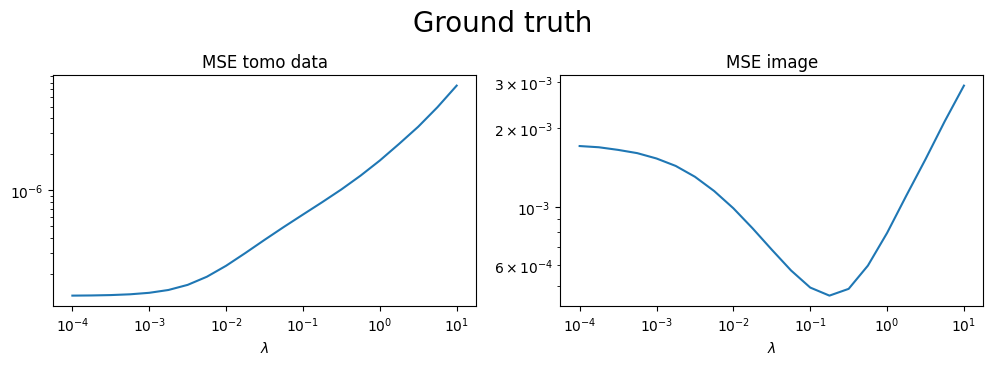

In [10]:
idx = 12
tomo_plots.plot_hyperparam_tuning_data(reg_param_tuning_data_anisotropic[idx])

Optimal regularization parameter analysis: **coherence-enhancing** regularization functional

In [12]:
best_performing_hyper_params = np.zeros(len(reg_param_tuning_data_coh_enhancing))
for i in range(best_performing_hyper_params.size):
    mse_argmin = np.argmin(reg_param_tuning_data_coh_enhancing[i]['GT'][2, :])
    best_performing_hyper_params[i] = reg_param_tuning_data_coh_enhancing[i]['GT'][0, mse_argmin]

[]

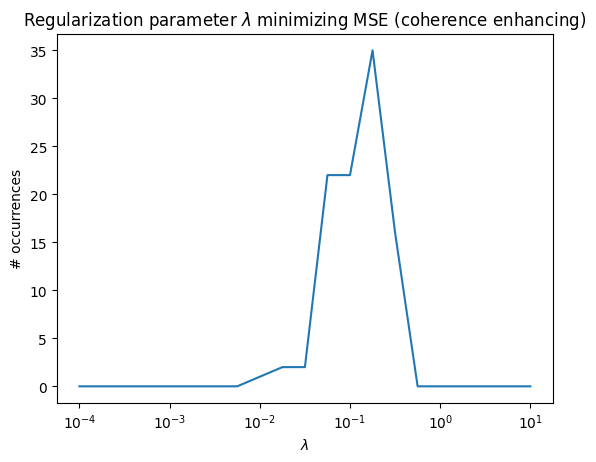

In [15]:
nb_occurrences = np.zeros(reg_param_tuning_data_coh_enhancing[0]["GT"].shape[1])
for i in range(len(reg_param_tuning_data_coh_enhancing)):
    j = np.argmin(reg_param_tuning_data_coh_enhancing[i]['GT'][2, :])
    nb_occurrences[j] += 1

plt.figure()
plt.plot(nb_occurrences)
plt.xticks([0,4,8,12,16,20], [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])
plt.title(r"Regularization parameter $\lambda$ minimizing MSE (coherence enhancing)")
plt.xlabel(r"$\lambda$")
plt.ylabel("# occurrences")
plt.plot()

In [16]:
print("Statistics on best performing regularization paramete (coherence enhancing)r\n")
print("Mean ", np.mean(best_performing_hyper_params))
print("Standard deviation ", np.std(best_performing_hyper_params))

Statistics on best performing regularization paramete (coherence enhancing)r

Mean  0.1482958424822855
Standard deviation  0.08943903260666382


Optimal regularization parameter analysis: **anisotropic** regularization functional

In [17]:
best_performing_hyper_params_aniso = np.zeros(len(reg_param_tuning_data_anisotropic))
for i in range(best_performing_hyper_params_aniso.size):
    mse_argmin = np.argmin(reg_param_tuning_data_anisotropic[i]['GT'][2, :])
    best_performing_hyper_params_aniso[i] = reg_param_tuning_data_anisotropic[i]['GT'][0, mse_argmin]

[]

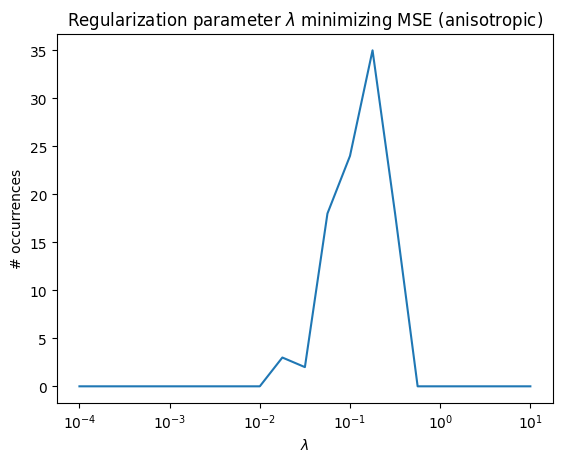

In [20]:
nb_occurrences = np.zeros(reg_param_tuning_data_anisotropic[0]["GT"].shape[1])
for i in range(len(reg_param_tuning_data_anisotropic)):
    j = np.argmin(reg_param_tuning_data_anisotropic[i]['GT'][2, :])
    nb_occurrences[j] += 1

plt.figure()
plt.plot(nb_occurrences)
plt.xticks([0,4,8,12,16,20], [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])
plt.title(r"Regularization parameter $\lambda$ minimizing MSE (anisotropic)")
plt.xlabel(r"$\lambda$")
plt.ylabel("# occurrences")
plt.plot()

In [21]:
print("Statistics on best performing regularization parameter (anisotropic)\n")
print("Mean ", np.mean(best_performing_hyper_params_aniso))
print("Standard deviation ", np.std(best_performing_hyper_params_aniso))

Statistics on best performing regularization parameter (anisotropic)

Mean  0.15444886044286477
Standard deviation  0.09062128960846134


**Set regularization parameter to average value found by above analysis**

In [23]:
reg_param = np.mean(best_performing_hyper_params_aniso)

How to infer anisotropic parameter? Analysis on same phantoms considered above

In [83]:
idxs_analysis = np.arange(900, 1000)

anis_param_tuning_data = []

for idx in idxs_analysis:
    print("phantom ", idx)
    ground_truth= copy.deepcopy(sxr_samples[idx,0,:,:].squeeze())
    psi=psis[idx,:,:]
    alpha=alphas[idx]
    trim_val_=trim_val[idx,:]
    mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val_)
    mask_core_fine = tomo_helps.define_core_mask(psi=psi, dim_shape=psi.shape, trim_values_x=trim_val_)

    # anisotropic regularization functional
    reg_fct_type = "anisotropic"
    # Define functionals
    f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi,
                                                     sigma_err=sigma_err, reg_fct_type=reg_fct_type,
                                                     alpha=alpha, plot=False,
                                                     seed=idx)
    # tune anisotropic parameter
    anis_param_data = hyper_tune.anis_param_tuning(f, g, reg_param,
                                                       tuning_techniques=["GT", "CV_single", "CV_full"], ground_truth=ground_truth,
                                                       with_pos_constraint=True, clipping_mask=mask_core,
                                                       cv_strategy="random",
                                                       anis_params=np.logspace(-4,0,13), plot=False)
    
    anis_param_tuning_data.append(anis_param_data)

phantom  900
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning anisotropy parameter: 1-fold cross validation (`CV_single`)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)

phantom  901
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning anisotropy parameter: 1-fold cross validation (`CV_single`)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)

phantom  902
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning anisotropy parameter: 1-fold cross validation (`CV_single`)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)

phantom  903
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning anisotropy parameter: 1-fold cross validation (`CV_single`)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)

phantom  904
Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning anisotropy parameter: 1-fold cross v

In [85]:
# save hyperparameter tuning data

# reg_param_tuning_data_coh_array = np.array(reg_param_tuning_data_coh_enhancing)
# np.save('hyperparameter_tuning_data/reg_param_coherence_enhancing.npy', reg_param_tuning_data_coh_array)
# reg_param_tuning_data_anis_array = np.array(reg_param_tuning_data_anisotropic)
# np.save('hyperparameter_tuning_data/reg_param_anisotropic.npy', reg_param_tuning_data_anis_array)
# 
# anis_param_tuning_data_array = np.array(anis_param_tuning_data)
# np.save('hyperparameter_tuning_data/anis_param.npy', anis_param_tuning_data_array)

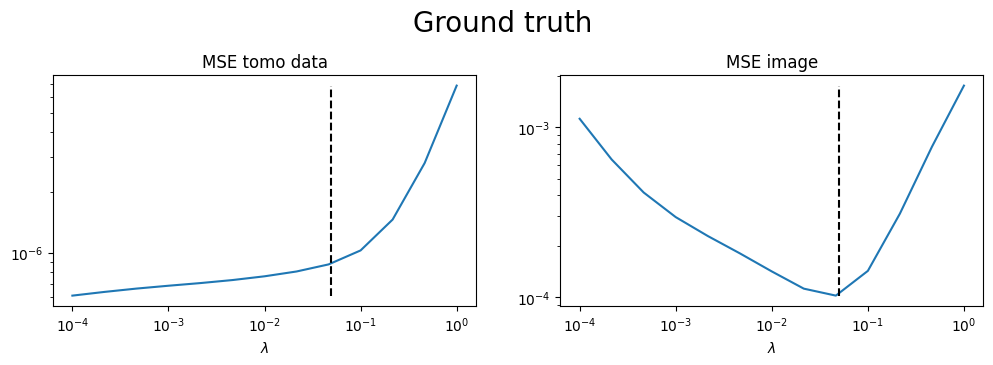

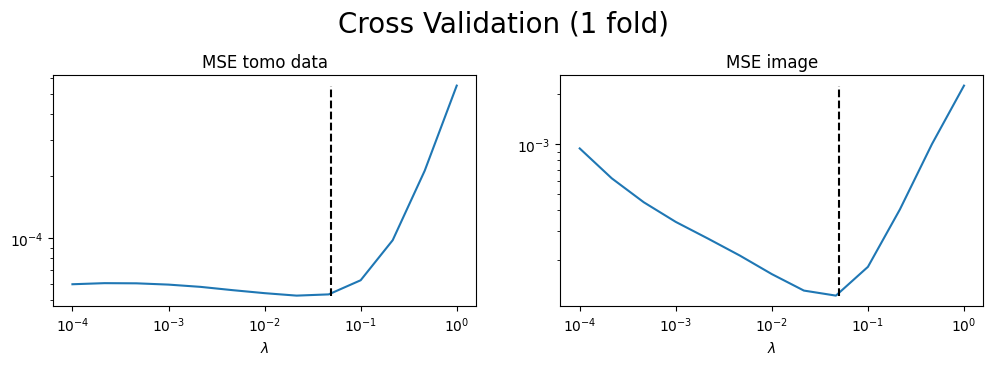

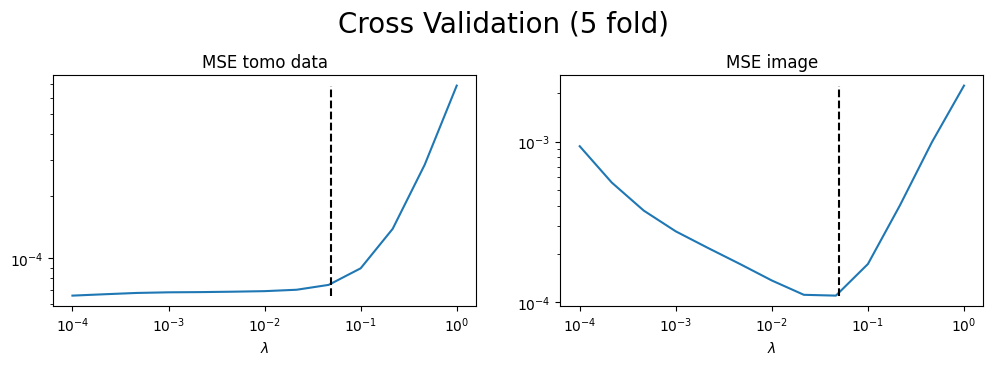

In [136]:
idx = 932
tomo_plots.plot_hyperparam_tuning_data(anis_param_tuning_data[idx-900], true_param_val=alphas[idx])

In [87]:
best_performing_anis_params = np.zeros((len(anis_param_tuning_data), 3))
for i in range(best_performing_anis_params.shape[0]):
    best_performing_anis_params[i, 0] = anis_param_tuning_data[i]['GT'][0, np.argmin(anis_param_tuning_data[i]['GT'][2, :])]
    best_performing_anis_params[i, 1] = anis_param_tuning_data[i]['CV_single'][0, np.argmin(anis_param_tuning_data[i]['CV_single'][1, :])]
    best_performing_anis_params[i, 2] = anis_param_tuning_data[i]['CV_full'][0, np.argmin(anis_param_tuning_data[i]['CV_full'][1, :])]

Text(0.5, 1.0, 'Comparing $\\alpha$ estimation techniques')

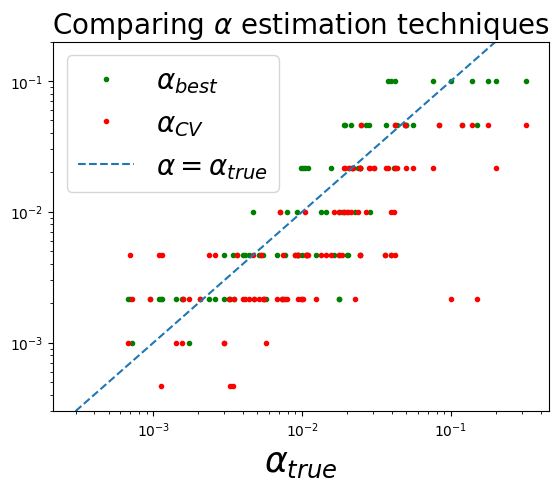

In [109]:
plt.figure()
plt.plot(alphas[900:1000], best_performing_anis_params[:, 0], 'g.', label=r"$\alpha_{best}$")
plt.plot(alphas[900:1000], best_performing_anis_params[:, 2], 'r.', label=r"$\alpha_{CV}$")
plt.plot(np.linspace(3e-4,2e-1), np.linspace(3e-4,2e-1), '--', label=r"$\alpha=\alpha_{true}$")
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\alpha_{true}$", fontsize=25)
plt.ylim([3e-4,2e-1])
plt.legend(loc="upper left", fontsize=20)
plt.title(r"Comparing $\alpha$ estimation techniques", fontsize=20)

In [129]:
factors_cv_wrt_best = np.zeros(100)
factors_true_wrt_best = np.zeros(100)
factors_cv_wrt_true = np.zeros(100)

idxs = np.arange(900,1000)

for i, idx in enumerate(idxs):
    
    # compute MSE for true alpha
    print("phantom ", idx)
    ground_truth= copy.deepcopy(sxr_samples[idx,0,:,:].squeeze())
    psi=psis[idx,:,:]
    alpha=alphas[idx]
    trim_val_=trim_val[idx,:]
    mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val_)
    mask_core_fine = tomo_helps.define_core_mask(psi=psi, dim_shape=psi.shape, trim_values_x=trim_val_)

    # anisotropic regularization functional
    reg_fct_type = "anisotropic"
    # Define functionals
    f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi,
                                                     sigma_err=sigma_err, reg_fct_type=reg_fct_type,
                                                     alpha=alpha, plot=False,
                                                     seed=idx)
    # compute MSE
    data = hyper_tune.anis_param_tuning(f, g, reg_param,
                                                       tuning_techniques=["GT"], ground_truth=ground_truth,
                                                       with_pos_constraint=True, clipping_mask=mask_core,
                                                       cv_strategy="random",
                                                       anis_params=np.array([alpha]), plot=False)
    mse_true_alpha = data['GT'][2, np.argmin(data['GT'][2, :])]
    
    # compute factors
    factors_cv_wrt_best[i] = anis_param_tuning_data[i]['GT'][2, np.argmin(anis_param_tuning_data[i]['CV_full'][1, :])] / anis_param_tuning_data[i]['GT'][2, np.argmin(anis_param_tuning_data[i]['GT'][2, :])]
    factors_true_wrt_best[i] = mse_true_alpha / anis_param_tuning_data[i]['GT'][2, np.argmin(anis_param_tuning_data[i]['GT'][2, :])]
    factors_cv_wrt_true[i] = anis_param_tuning_data[i]['GT'][2, np.argmin(anis_param_tuning_data[i]['CV_full'][1, :])] / mse_true_alpha

phantom  900
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  901
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  902
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  903
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  904
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  905
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  906
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  907
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  908
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  909
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  910
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  911
Tuning regularization parameter: comparison to ground truth (`GT`)

phantom  912
Tuning regulari

In [132]:
print(" Mean and std (CV wrt best parameter) ", np.mean(factors_cv_wrt_best), np.std(factors_cv_wrt_best))

print("\n Mean and std (true wrt best parameter) ", np.mean(factors_true_wrt_best), np.std(factors_true_wrt_best))

print("\n Mean and std (cv wrt true parameter) ", np.mean(factors_cv_wrt_true), np.std(factors_cv_wrt_true))

 Mean and std (CV wrt best parameter)  1.25227532698608 1.0235906300493898

 Mean and std (true wrt best parameter)  1.0963264733184195 0.17128728774191748

 Mean and std (cv wrt true parameter)  1.1700871779389774 1.0291994596349918


(0.0, 12.0)

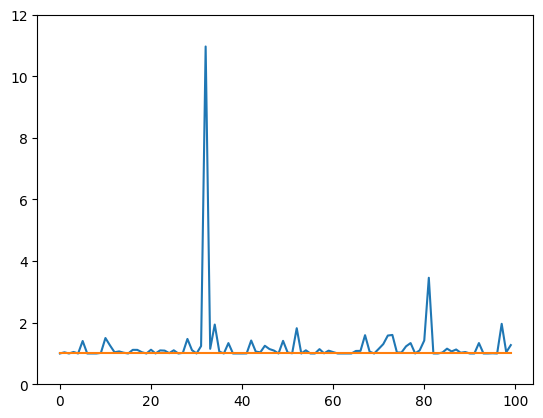

In [139]:
plt.plot(factors_cv_wrt_best)
plt.plot(np.ones(100))
plt.ylim([0,12])

Determine number of ULA iterations necessary to estimate moments (mean, variance, ...)

# Uncertainty Quantification

In [151]:
idxs = np.arange(0,2)

uq_data = []

for i, idx in enumerate(idxs):
    
    # compute MSE for true alpha
    print("phantom ", idx)
    ground_truth= copy.deepcopy(sxr_samples[idx,0,:,:].squeeze())
    psi=psis[idx,:,:]
    alpha=alphas[idx]
    trim_val_=trim_val[idx,:]
    mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val_)
    mask_core_fine = tomo_helps.define_core_mask(psi=psi, dim_shape=psi.shape, trim_values_x=trim_val_)

    # anisotropic regularization functional
    reg_fct_type = "anisotropic"
    # Define functionals
    f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi,
                                                     sigma_err=sigma_err, reg_fct_type=reg_fct_type,
                                                     alpha=alpha, plot=False,
                                                     seed=idx)

    # tune anisotropic parameter
    anis_param_data_ = hyper_tune.anis_param_tuning(f, g, reg_param,
                                                       tuning_techniques=["CV_full"],
                                                       with_pos_constraint=True, clipping_mask=mask_core,
                                                       cv_strategy="random",
                                                       anis_params=np.logspace(-4,0,13), plot=False)


    g = hyper_tune._redefine_anis_param_logprior(g, anis_param_data_["CV_full"][0, np.argmin(anis_param_data_["CV_full"][1,:])])

    uq_data_ = bcomp.run_ula(f, g, reg_param, psi, trim_val_,
                with_pos_constraint=True,
                clip_iterations="core",
                compute_stats_wrt_MAP=True,
                estimate_quantiles=True)
    
    uq_data.append(uq_data_)

phantom  0
Tuning regularization parameter: 5-fold cross validation (`CV_full`)

INFO -- [2024-12-17 10:46:53.202461] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0


/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu_diffops/operator/diffusion/_diffusion_coeff.py:147: UserWarning: DiffusionCoefficient had already been frozen. Overwriting previous frozen state.
  warnings.warn("DiffusionCoefficient had already been frozen. Overwriting previous frozen state.")


INFO -- [2024-12-17 10:46:53.967685] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2024-12-17 10:46:54.064083] Iteration 1_139
	iteration: 1139
	N_iter: 1140
	RelError[x]: 0
INFO -- [2024-12-17 10:46:54.065126] Stopping Criterion satisfied -> END
Running 100000 ULA iterations
iteration  10000
iteration  20000
iteration  30000
iteration  40000
iteration  50000
iteration  60000
iteration  70000
iteration  80000
iteration  90000
iteration  100000
phantom  1
Tuning regularization parameter: 5-fold cross validation (`CV_full`)

INFO -- [2024-12-17 10:48:49.092661] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0


/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu_diffops/operator/diffusion/_diffusion_coeff.py:147: UserWarning: DiffusionCoefficient had already been frozen. Overwriting previous frozen state.
  warnings.warn("DiffusionCoefficient had already been frozen. Overwriting previous frozen state.")


INFO -- [2024-12-17 10:48:49.847090] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2024-12-17 10:48:50.037470] Iteration 1_249
	iteration: 1249
	N_iter: 1250
	RelError[x]: 0
INFO -- [2024-12-17 10:48:50.038372] Stopping Criterion satisfied -> END
Running 100000 ULA iterations
iteration  10000
iteration  20000
iteration  30000
iteration  40000
iteration  50000
iteration  60000
iteration  70000
iteration  80000
iteration  90000
iteration  100000


In [155]:
idx = 0

# compute MSE for true alpha
ground_truth= copy.deepcopy(sxr_samples[idx,0,:,:].squeeze())
psi=psis[idx,:,:]
alpha=alphas[idx]
trim_val_=trim_val[idx,:]
mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val_)
mask_core_fine = tomo_helps.define_core_mask(psi=psi, dim_shape=psi.shape, trim_values_x=trim_val_)

uq_data_full = copy.deepcopy(uq_data)

uq_data = uq_data_full[idx]

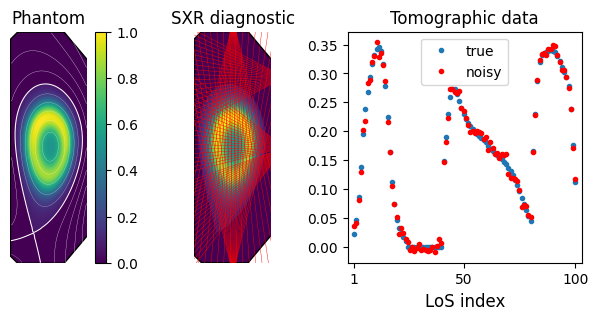

In [157]:
tomo_plots.plot_phantom_and_sxr_diag(ground_truth=ground_truth, psi=psi, f=f, tcv_plot_clip=True)

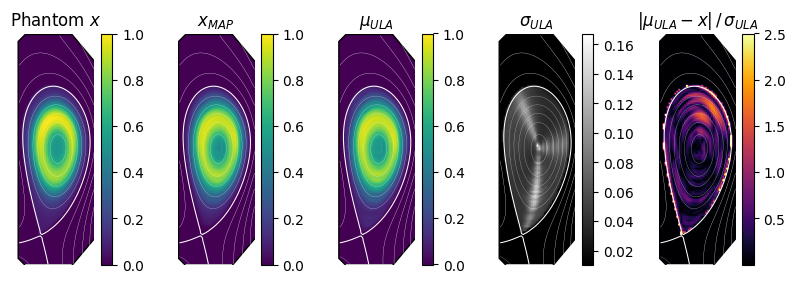

In [158]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_nb_stds=True,
                        cmaps=["viridis", "viridis", "viridis", "gray", "inferno"],
                        vmax_std=np.max(np.sqrt(uq_data["var"])), vmax_nb_std=2.5)

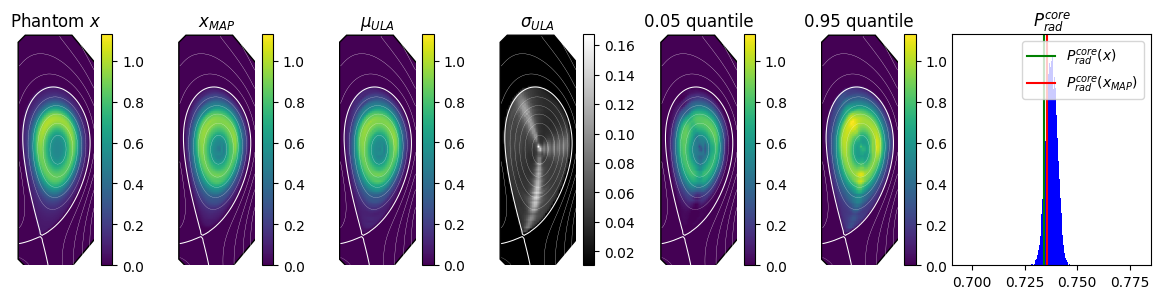

In [159]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_quantiles=True, plot_prad=True,
                        mask_core=mask_core,
                        cmaps=["viridis", "viridis", "viridis", "gray", "viridis", "viridis"], vmax_std=np.max(np.sqrt(uq_data["var"])))

In [160]:
gt_coarse = skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
idxs =  np.where( (gt_coarse>=uq_data["empirical_quantiles"][1,:,:]) & (gt_coarse<=uq_data["empirical_quantiles"][-2,:,:]))
frac_pixels_within_quantiles = idxs[0].size / 4800
frac_pixels_within_quantiles_core = (idxs[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
print("Percentage of pixels within 90% posterior quantiles (core) ", frac_pixels_within_quantiles_core)

Percentage of pixels within 90% posterior quantiles (core)  0.9568788501026694


In [186]:
print("Predicted emissivity peak location (mean +- std) ", uq_data["mean_peak_loc"], "+-", np.sqrt(uq_data["var_peak_loc"]))
print("True location of peak emissivity ", np.array(np.where(ground_truth==ground_truth.max())).reshape(2)/2)

Predicted emissivity peak location (mean +- std)  [51.4012  17.67054] +- [9.7345785  4.32063145]
True location of peak emissivity  [46.  15.5]


Text(0.5, 1.0, 'Tomographic measurements: ULA predictions vs true measurements')

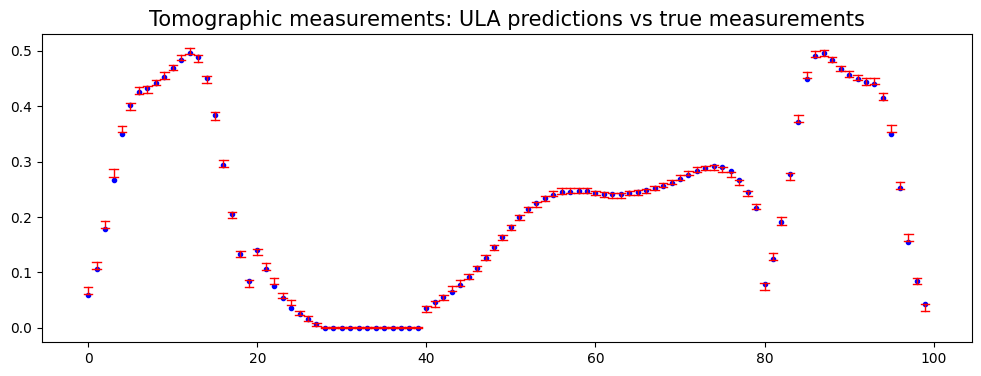

In [179]:
plt.figure(figsize=(12,4))
plt.plot(uq_data["tomo_data"], 'b.')
for i in range(uq_data["tomo_data"].size):
    tomo_plots.plot_errbar(i, uq_data["mean_tomo_data"][i], np.sqrt(uq_data["var_tomo_data"][i]),
                           left=0.5, right=0.5, linewidth=1)
plt.title("Tomographic measurements: ULA predictions vs true measurements", fontsize=15)

# Study ULA hyperparameters

In [148]:
ula_study = []

for i in range(10):
    ula_data = np.load('ula_iterations_number_tuning_fine_anisotropic_newbounds_sigma005/ula_data_'+str(900+i)+'.npy',allow_pickle=True)
    ula_study.append(ula_data.item())

(1.0, 1995469.722999839)

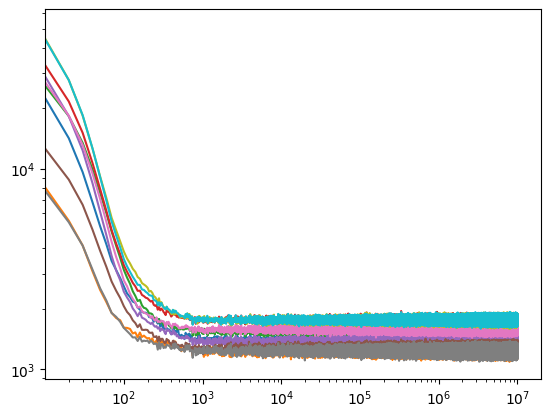

In [249]:
plt.figure()
for i in range(len(ula_study)):
    plt.plot(ula_study[i]["ula_obj_values"])
plt.xscale("log")
plt.yscale("log")
plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6],
           [r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
plt.xlim([1,None])

In [213]:
ula_study[0]["ula_obj_values"][:10]

array([37824., 22544., 14200.,  9616.,  6808.,  5168.,  4200.,  3468.,
        3118.,  2846.], dtype=float16)

(1, 1000.0)

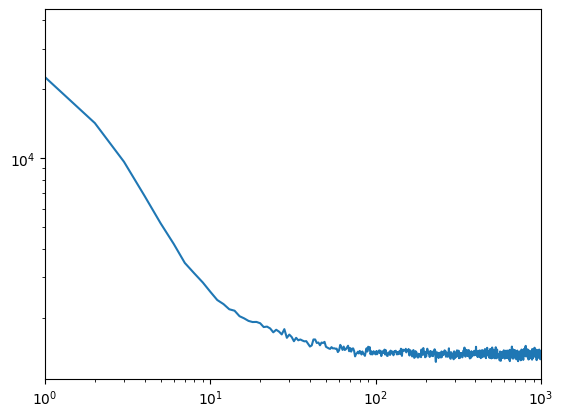

In [248]:
plt.plot(ula_study[0]["ula_obj_values"][:1000])
plt.yscale("log")
plt.xscale("log")
plt.xlim([1,1e3])

In [6]:
ula_study[0].keys()

dict_keys(['tomo_data', 'noisy_tomo_data', 'sigma_err', 'reg_param', 'sampling', 'alpha', 'with_pos_constraint', 'clip_iterations', 'samples', 'mean_10', 'var_10', 'mean_prad_10', 'var_prad_10', 'time_10', 'mean_25', 'var_25', 'mean_prad_25', 'var_prad_25', 'time_25', 'mean_50', 'var_50', 'mean_prad_50', 'var_prad_50', 'time_50', 'mean_75', 'var_75', 'mean_prad_75', 'var_prad_75', 'time_75', 'mean_100', 'var_100', 'mean_prad_100', 'var_prad_100', 'time_100', 'mean_250', 'var_250', 'mean_prad_250', 'var_prad_250', 'time_250', 'mean_500', 'var_500', 'mean_prad_500', 'var_prad_500', 'time_500', 'mean_750', 'var_750', 'mean_prad_750', 'var_prad_750', 'time_750', 'mean_1000', 'var_1000', 'mean_prad_1000', 'var_prad_1000', 'time_1000', 'mean_2500', 'var_2500', 'mean_prad_2500', 'var_prad_2500', 'time_2500', 'mean_5000', 'var_5000', 'mean_prad_5000', 'var_prad_5000', 'time_5000', 'mean_7500', 'var_7500', 'mean_prad_7500', 'var_prad_7500', 'time_7500', 'mean_10000', 'var_10000', 'mean_prad_100

In [389]:
print(ula_study[0]["time_10000000"])

3648.6944987773895


In [151]:
mean_items, var_items, mean_prad_items, var_prad_items = [], [], [], []
for k in ula_study[0].keys():
    if 'mean' in k and 'prad' not in k:
        mean_items.append(ula_study[0][k])
    if 'var' in k and 'prad' not in k:
        var_items.append(ula_study[0][k])
    if 'mean_prad' in k:
        mean_prad_items.append(ula_study[0][k])
    if 'var_prad' in k:
        var_prad_items.append(ula_study[0][k])
mean_items, var_items = np.array(mean_items), np.array(var_items)
mean_prad_items, var_prad_items = np.array(mean_prad_items), np.array(var_prad_items)

In [152]:
mse_mean = np.mean((mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))**2, axis=(1,2))
mse_var = np.mean((var_items-np.stack([var_items[-1]]*var_items.shape[0]))**2, axis=(1,2))
mse_mean_prad = np.mean((mean_prad_items-np.stack([mean_prad_items[-1]]*mean_prad_items.shape[0]))**2, axis=1)
mse_var_prad = np.mean((var_prad_items-np.stack([var_prad_items[-1]]*var_prad_items.shape[0]))**2, axis=1)

In [336]:
mapes_mean, mapes_var = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)) 
mses_mean, mses_var = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)) 

for i in range(len(ula_study)):
    
    mean_items, var_items, mean_prad_items, var_prad_items = [], [], [], []
    for k in ula_study[i].keys():
        if 'mean' in k and 'prad' not in k:
            mean_items.append(ula_study[i][k])
        if 'var' in k and 'prad' not in k:
            var_items.append(ula_study[i][k])
        if 'mean_prad' in k:
            mean_prad_items.append(ula_study[i][k])
        if 'var_prad' in k:
            var_prad_items.append(ula_study[i][k])
    mean_items, var_items = np.array(mean_items), np.array(var_items)
    mean_prad_items, var_prad_items = np.array(mean_prad_items), np.array(var_prad_items)
    
    
    mses_mean[i,:] = np.mean((mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))**2, axis=(1,2))
    mape_mean = np.abs(mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))
    mean_positive_locs = np.where(mean_items[-1]>1e-3)
    mape_mean[:,mean_positive_locs[0], mean_positive_locs[1]] /= mean_items[-1][mean_positive_locs[0], mean_positive_locs[1]]
    mapes_mean[i,:] = np.mean(mape_mean[:,mean_positive_locs[0],mean_positive_locs[1]],axis=1)
    
    mses_var[i,:] = np.mean((var_items-np.stack([var_items[-1]]*var_items.shape[0]))**2, axis=(1,2))
    mape_var = np.abs(var_items-np.stack([var_items[-1]]*var_items.shape[0]))
    var_positive_locs = np.where(var_items[-1]>1e-3)
    mape_var[:,var_positive_locs[0], var_positive_locs[1]] /= var_items[-1][var_positive_locs[0], var_positive_locs[1]]
    mapes_var[i,:] = np.mean(mape_var[:,var_positive_locs[0],var_positive_locs[1]],axis=1)


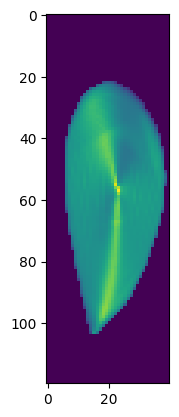

In [297]:
plt.imshow(var_items[-1])

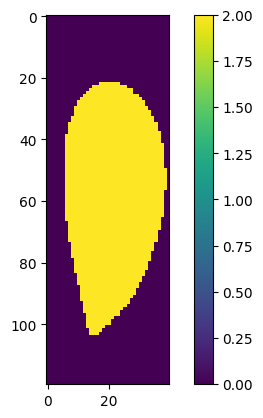

In [306]:
ff=copy.deepcopy(mean_items[-1])
ff[ff>1e-3]=2
plt.imshow(ff)
plt.colorbar()

In [272]:
mapes_mean.shape

(10, 25)

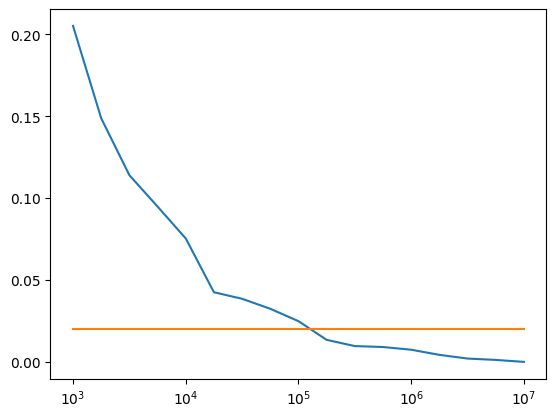

In [310]:
plt.plot(mapes_mean[0,8:])
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
plt.plot(np.ones(int(17))*0.02)

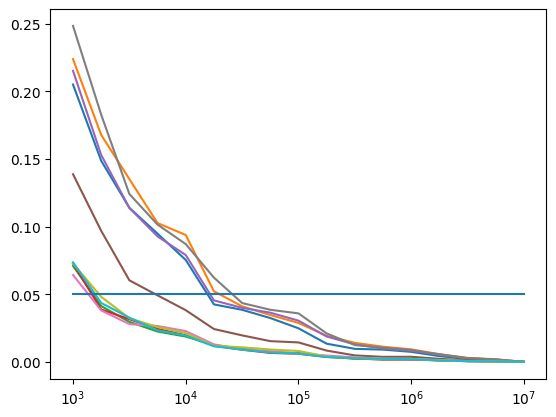

In [311]:
for i in range(len(ula_study)):
    plt.plot(mapes_mean[i,8:])
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
plt.plot(np.ones(int(17))*0.05)

Text(0.5, 1.0, 'MAPE $\\sigma_{_{ULA}}$')

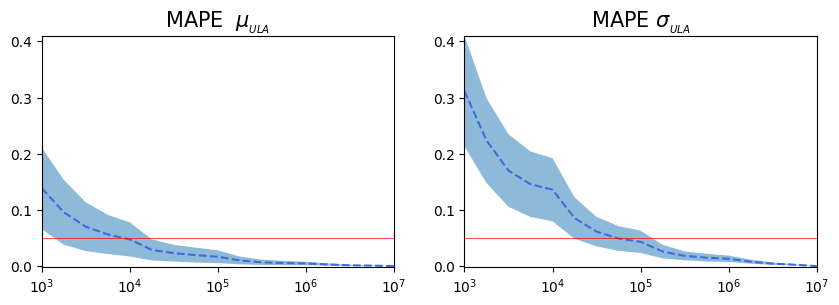

In [380]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(wspace=0.2)

mape_mean_avg = np.mean(mapes_mean[:,8:],axis=0)
mape_mean_std = np.std(mapes_mean[:,8:],axis=0)
ax[0].plot(mape_mean_avg, '--', color="royalblue")
ax[0].fill_between(np.arange(0,17), mape_mean_avg-mape_mean_std,  mape_mean_avg+mape_mean_std, alpha=0.5)
ax[0].set_xticks([0,4,8,12,16])
ax[0].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
ax[0].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
ax[0].set_ylim([-0.001,0.41])
ax[0].set_xlim([0,16])
ax[0].set_title(r"MAPE $\;\mu_{_{ULA}}$", fontsize=15)

mape_var_avg = np.mean(mapes_var[:,8:],axis=0)
mape_var_std = np.std(mapes_var[:,8:],axis=0)
ax[1].plot(mape_var_avg, '--', color="royalblue")
ax[1].fill_between(np.arange(0,17), mape_var_avg-mape_var_std,  mape_var_avg+mape_var_std, alpha=0.5)
ax[1].set_xticks([0,4,8,12,16])
ax[1].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
ax[1].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
ax[1].set_ylim([-0.001,0.41])
ax[1].set_xlim([0,16])
ax[1].set_title(r"MAPE $\sigma_{_{ULA}}$", fontsize=15)
#ax[1].set_xlabel(r"$N_{ULA}$")

Text(0.5, 1.0, 'MSE $\\sigma_{_{ULA}}$')

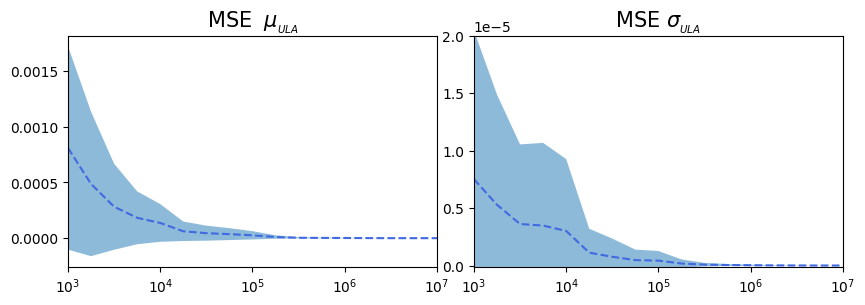

In [373]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(wspace=0.1)
mse_mean_avg = np.mean(mses_mean[:,8:],axis=0)
mse_mean_std = np.std(mses_mean[:,8:],axis=0)
ax[0].plot(mse_mean_avg, '--', color="royalblue")
ax[0].fill_between(np.arange(0,17), mse_mean_avg-mse_mean_std,  mse_mean_avg+mse_mean_std, alpha=0.5)
ax[0].set_xticks([0,4,8,12,16])
ax[0].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
#ax[0].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
#ax[0].set_ylim([-0.001,0.41])
ax[0].set_xlim([0,16])
ax[0].set_title(r"MSE $\;\mu_{_{ULA}}$", fontsize=15)

mse_var_avg = np.mean(mses_var[:,8:],axis=0)
mse_var_std = np.std(mses_var[:,8:],axis=0)
ax[1].plot(mse_var_avg, '--', color="royalblue")
ax[1].fill_between(np.arange(0,17), mse_var_avg-mse_var_std,  mse_var_avg+mse_var_std, alpha=0.5)
ax[1].set_xticks([0,4,8,12,16])
ax[1].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
#ax[1].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
ax[1].set_ylim([-1e-7,2e-5])
ax[1].set_xlim([0,16])
ax[1].set_title(r"MSE $\sigma_{_{ULA}}$", fontsize=15)

(0.0, 16.0)

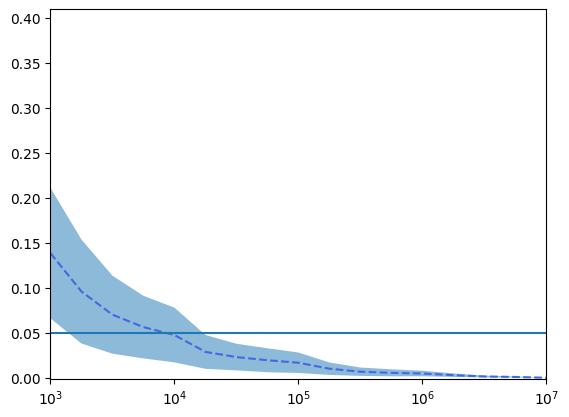

In [335]:
mape_mean_avg = np.mean(mapes_mean[:,8:],axis=0)
mape_mean_std = np.std(mapes_mean[:,8:],axis=0)
plt.plot(mape_mean_avg, '--', color="royalblue")
plt.fill_between(np.arange(0,17), mape_mean_avg-mape_mean_std,  mape_mean_avg+mape_mean_std, alpha=0.5)
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
plt.plot(np.ones(int(17))*0.05)
plt.ylim([-0.001,0.41])
plt.xlim([0,16])



(0.0, 16.0)

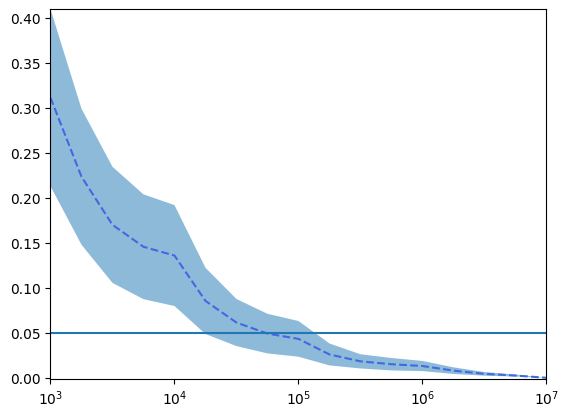

In [334]:
mape_var_avg = np.mean(mapes_var[:,8:],axis=0)
mape_var_std = np.std(mapes_var[:,8:],axis=0)
plt.plot(mape_var_avg, '--', color="royalblue")
plt.fill_between(np.arange(0,17), mape_var_avg-mape_var_std,  mape_var_avg+mape_var_std, alpha=0.5)
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
plt.plot(np.ones(int(17))*0.05)
plt.ylim([-0.001,0.41])
plt.xlim([0,16])

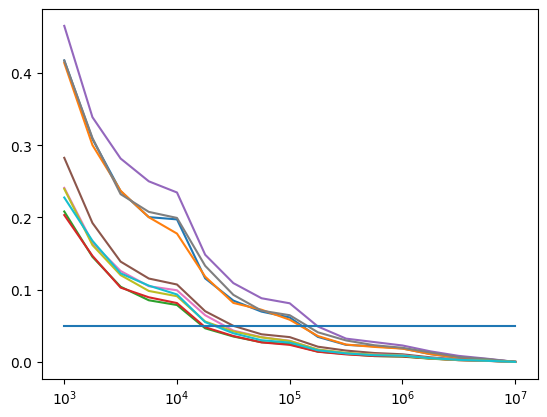

In [330]:
for i in range(len(ula_study)):
    plt.plot(mapes_var[i,8:])
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
plt.plot(np.ones(int(17))*0.05)

In [153]:
mae_mean = np.mean(np.abs(mean_items-np.stack([mean_items[-1]]*mean_items.shape[0])), axis=(1,2))
mae_var = np.mean(np.abs(var_items-np.stack([var_items[-1]]*var_items.shape[0])), axis=(1,2))
mae_mean_prad = np.mean(np.abs(mean_prad_items-np.stack([mean_prad_items[-1]]*mean_prad_items.shape[0])), axis=1)
mae_var_prad = np.mean(np.abs(var_prad_items-np.stack([var_prad_items[-1]]*var_prad_items.shape[0])), axis=1)

([<matplotlib.axis.XTick at 0x7dba3f9002c0>,
 [Text(0, 0, '$10^1$'),
  Text(4, 0, '$10^2$'),
  Text(8, 0, '$10^3$'),
  Text(12, 0, '$10^4$'),
  Text(16, 0, '$10^5$'),
  Text(20, 0, '$10^6$'),
  Text(24, 0, '$10^7$')])

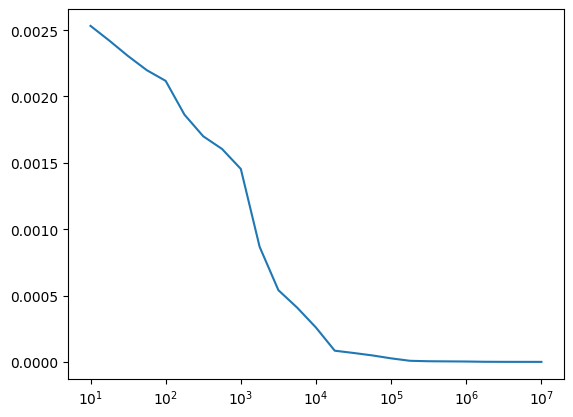

In [157]:
plt.plot(mse_mean)
#plt.yscale('log')
plt.xticks([0,4,8,12,16,20,24], [r"$10^1$",r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
#plt.ylim([1e-7,1e-1])

([<matplotlib.axis.XTick at 0x7dba3ffe5ee0>,
 [Text(0, 0, '$10^1$'),
  Text(4, 0, '$10^2$'),
  Text(8, 0, '$10^3$'),
  Text(12, 0, '$10^4$'),
  Text(16, 0, '$10^5$'),
  Text(20, 0, '$10^6$'),
  Text(24, 0, '$10^7$')])

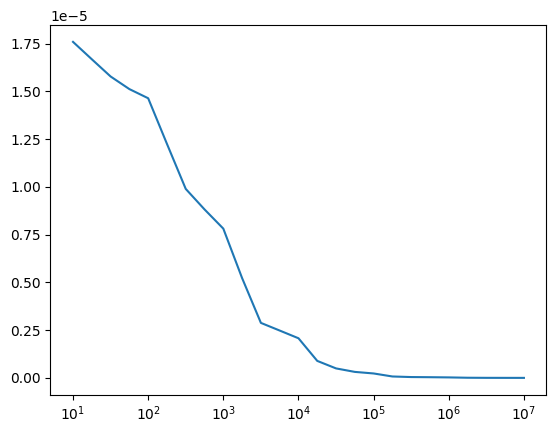

In [158]:
plt.plot(mse_var)
#plt.yscale('log')
plt.xticks([0,4,8,12,16,20,24], [r"$10^1$",r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
#plt.ylim([1e-7,1e-1])

([<matplotlib.axis.XTick at 0x7dba3c933260>,
 [Text(0, 0, '$10^3$'),
  Text(4, 0, '$10^4$'),
  Text(8, 0, '$10^5$'),
  Text(12, 0, '$10^6$'),
  Text(16, 0, '$10^7$')])

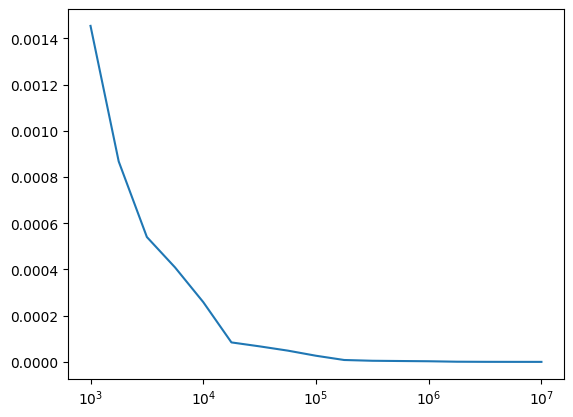

In [167]:
plt.plot(mse_mean[8:])
#plt.yscale('log')
plt.xticks([0,4,8,12, 16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
#plt.ylim([1e-7,1e-1])

([<matplotlib.axis.XTick at 0x7dba3c49aa50>,
 [Text(0, 0, '$10^1$'),
  Text(4, 0, '$10^2$'),
  Text(8, 0, '$10^3$'),
  Text(12, 0, '$10^4$'),
  Text(16, 0, '$10^5$'),
  Text(20, 0, '$10^6$'),
  Text(24, 0, '$10^7$')])

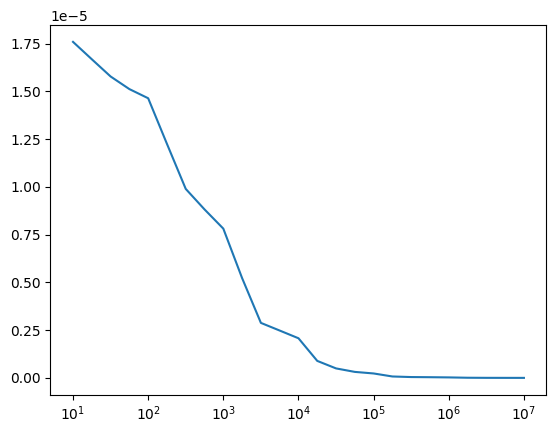

In [170]:
plt.plot(mse_var)
#plt.yscale('log')
plt.xticks([0,4,8,12,16,20,24], [r"$10^1$",r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
#plt.ylim([1e-7,1e-1])

([<matplotlib.axis.XTick at 0x7dba40763260>,
 [Text(0, 0, '$10^3$'),
  Text(4, 0, '$10^4$'),
  Text(8, 0, '$10^5$'),
  Text(12, 0, '$10^6$')])

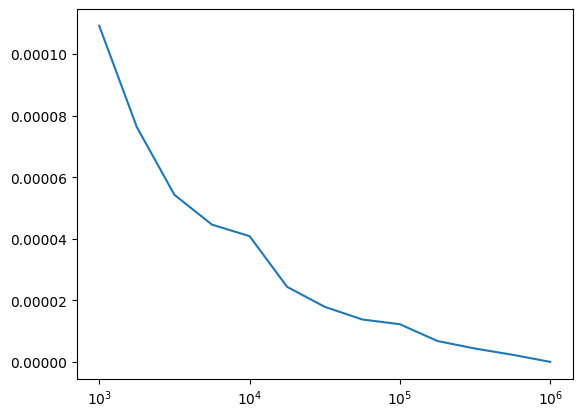

In [147]:
plt.plot(mae_var[8:])
#plt.yscale('log')
plt.xticks([0,4,8,12], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$"])
#plt.ylim([1e-7,1e-1])

(1e-07, 0.1)

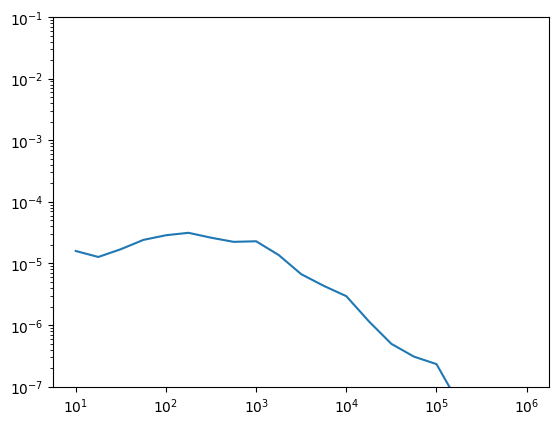

In [9]:
plt.plot(mse_var)
plt.yscale('log')
plt.xticks([0,4,8,12,16,20], [r"$10^1$",r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$"])
plt.ylim([1e-7,1e-1])

([<matplotlib.axis.XTick at 0x7dba424fe630>,
 [Text(0, 0, '$10^1$'),
  Text(4, 0, '$10^2$'),
  Text(8, 0, '$10^3$'),
  Text(12, 0, '$10^4$'),
  Text(16, 0, '$10^5$'),
  Text(20, 0, '$10^6$')])

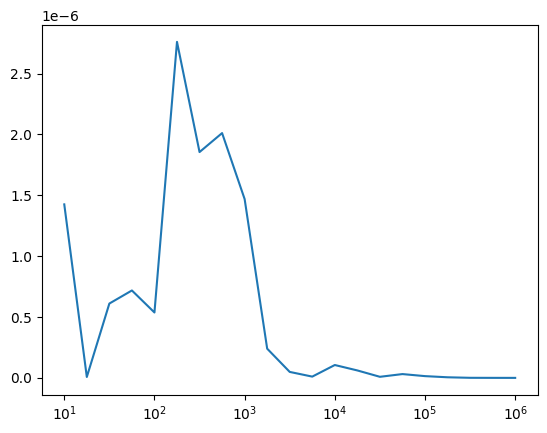

In [116]:
plt.plot(mse_mean_prad)
#plt.yscale('log')
plt.xticks([0,4,8,12,16,20], [r"$10^1$",r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$"])
#plt.ylim([1e-7,1e-1])

([<matplotlib.axis.XTick at 0x7dba3f507440>,
 [Text(0, 0, '$10^3$'),
  Text(4, 0, '$10^4$'),
  Text(8, 0, '$10^5$'),
  Text(12, 0, '$10^6$')])

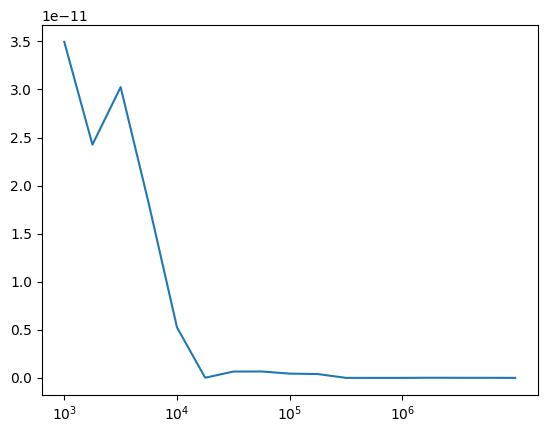

In [160]:
plt.plot(mse_var_prad[8:])
#plt.yscale('log')
plt.xticks([0,4,8,12], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$"])
#plt.ylim([1e-7,1e-1])

In [161]:
print(np.sqrt(var_prad_items))

[[0.00107789]
 [0.00120207]
 [0.00098565]
 [0.00132543]
 [0.00125565]
 [0.0022618 ]
 [0.00266368]
 [0.00237585]
 [0.00260569]
 [0.00278852]
 [0.00268366]
 [0.00290627]
 [0.00322652]
 [0.00358172]
 [0.00344832]
 [0.00344727]
 [0.00346924]
 [0.00347436]
 [0.00355965]
 [0.00356658]
 [0.00356004]
 [0.00357951]
 [0.00357607]
 [0.003576  ]
 [0.00356388]]


([<matplotlib.axis.XTick at 0x7dba3c449eb0>,
 [Text(0, 0, '$10^1$'),
  Text(4, 0, '$10^2$'),
  Text(8, 0, '$10^3$'),
  Text(12, 0, '$10^4$'),
  Text(16, 0, '$10^5$'),
  Text(20, 0, '$10^6$')])

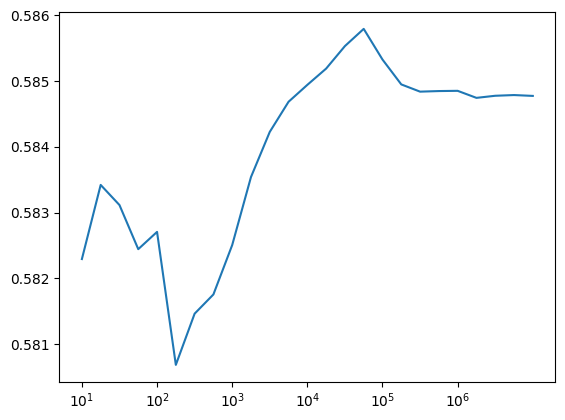

In [171]:
plt.plot(mean_prad_items)
#plt.yscale('log')
plt.xticks([0,4,8,12,16,20], [r"$10^1$",r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$"])
#plt.ylim([1e-7,1e-1])

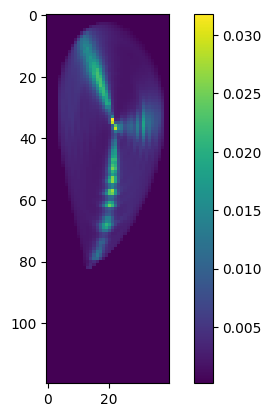

In [175]:
plt.imshow(var_items[24,:,:])
plt.colorbar()

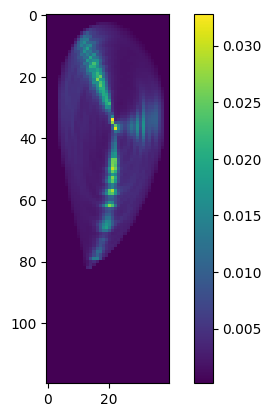

In [176]:
plt.imshow(var_items[16,:,:])
plt.colorbar()

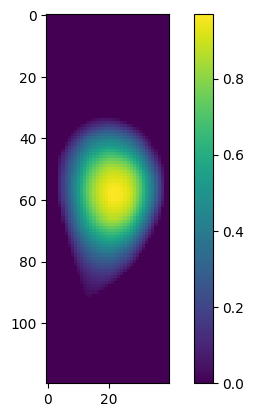

In [133]:
plt.imshow(mean_items[20,:,:])
plt.colorbar()

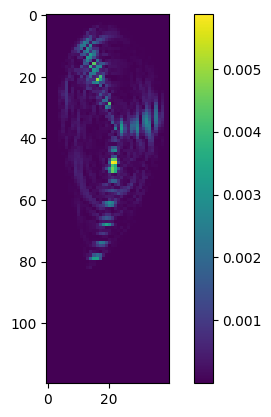

In [174]:
plt.imshow(np.abs(var_items[24,:,:]-var_items[16,:,:]))
plt.colorbar()

In [173]:
len(var_items)

25

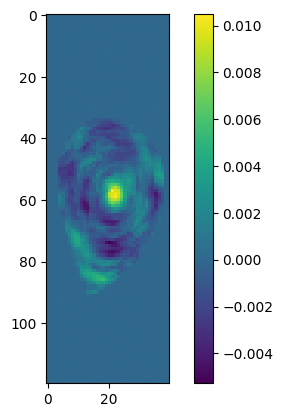

In [141]:
plt.imshow(mean_items[16,:,:]-mean_items[20,:,:])
plt.colorbar()

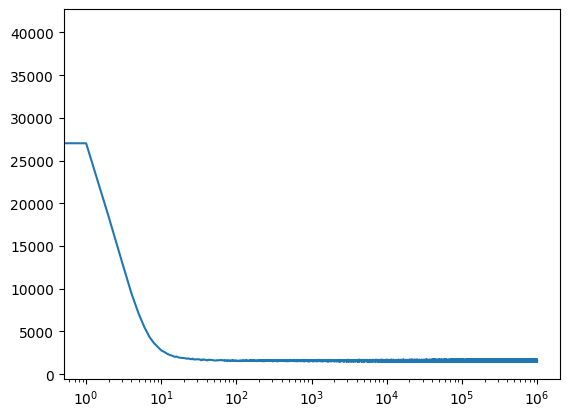

In [177]:
plt.plot(ula_study[6]["ula_obj_values"])
plt.xticks([0,1e1,1e2,1e3,1e4,1e5,1e6-1], [r"$10^0$", r"$10^1$",r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$"])
plt.xscale("log")

([<matplotlib.axis.XTick at 0x7dba3737fe90>,
 [Text(7.0, 0, '$10^1$'),
  Text(97.0, 0, '$10^2$'),
  Text(997.0, 0, '$10^3$'),
  Text(9997.0, 0, '$10^4$'),
  Text(99997.0, 0, '$10^5$'),
  Text(999996.0, 0, '$10^6$')])

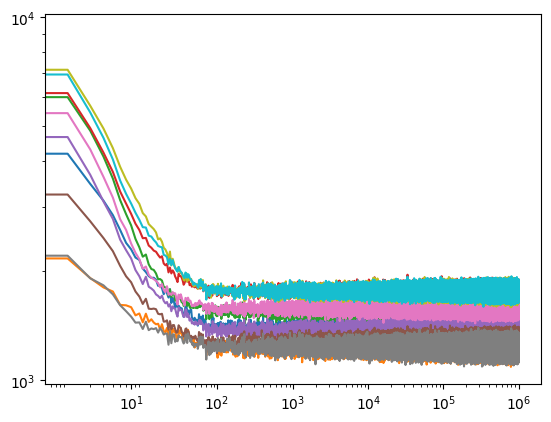

In [210]:
plt.figure()
for i in range(len(ula_study)):
    plt.plot(ula_study[i]["ula_obj_values"][5:])
plt.xscale("log")
plt.yscale("log")
plt.xticks([1e1-3,1e2-3,1e3-3,1e4-3,1e5-3,1e6-4], [r"$10^1$",r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$"])

In [75]:
ula_study[9]["ula_obj_values"][:10]

array([   inf,    inf,    inf, 62464., 59456., 56224., 53600., 51136.,
       48704., 46560.], dtype=float16)